In [1]:
# first result: we are really only detecting stars with non-zero
# RV shifts in the synthetic spectra
# note: as we can see in figure B3, we are really only detecting stars with drv>0,
# or abs(drv)>3km/s
# we also mostly detect binaries with q=0.8-1, especially for hot stars
# takeaway: having a non-zero RV shift matters more than a low q for these stars. 
# As a result, we can't find too many low q binaries, but we can find a lot of q=1 with 
# even a small RV shift. and we still find some with q=0.5
# my interpretation is because even a q=0.8 is too dim for these spectra,
# especially without the calcium lines.

# another takeaway: there is a small amount of low training density 
# binaries in the suspected binaries for which the labels definitely can't be trusted

# another takeaway: vbroad is negative sometimes, so I put in a hard bound.

# another takeaway: I think the reason we don't do too well on the relative RVs is because the 
# spectra are epoch-averaged with some uncertainties?

# another takeaway: the optimizer performs worse after cleaning training set because
# it loses the low/high teff stars, I think I need to include the test set and validate
# using leave-one-out validation

# final takeaway: I think this is working fine enough to move on to the real binaries.
# we aren't very precisely characterizing the binaries, but we are confidently 
# finding a lot of them.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import custom_model
fileroot = './data/binary_metric_dataframes/'
sim_binaries_filename = fileroot+'semi_empirical_binary_metrics_leastsq_drv26_logvbroad.csv'
singles_filename = fileroot+'single_metrics_leastsq_logvbroad.csv'
sim_binaries = pd.read_csv(sim_binaries_filename)
singles = pd.read_csv(singles_filename)

Text(0.5, 0, 'q=m2/m1')

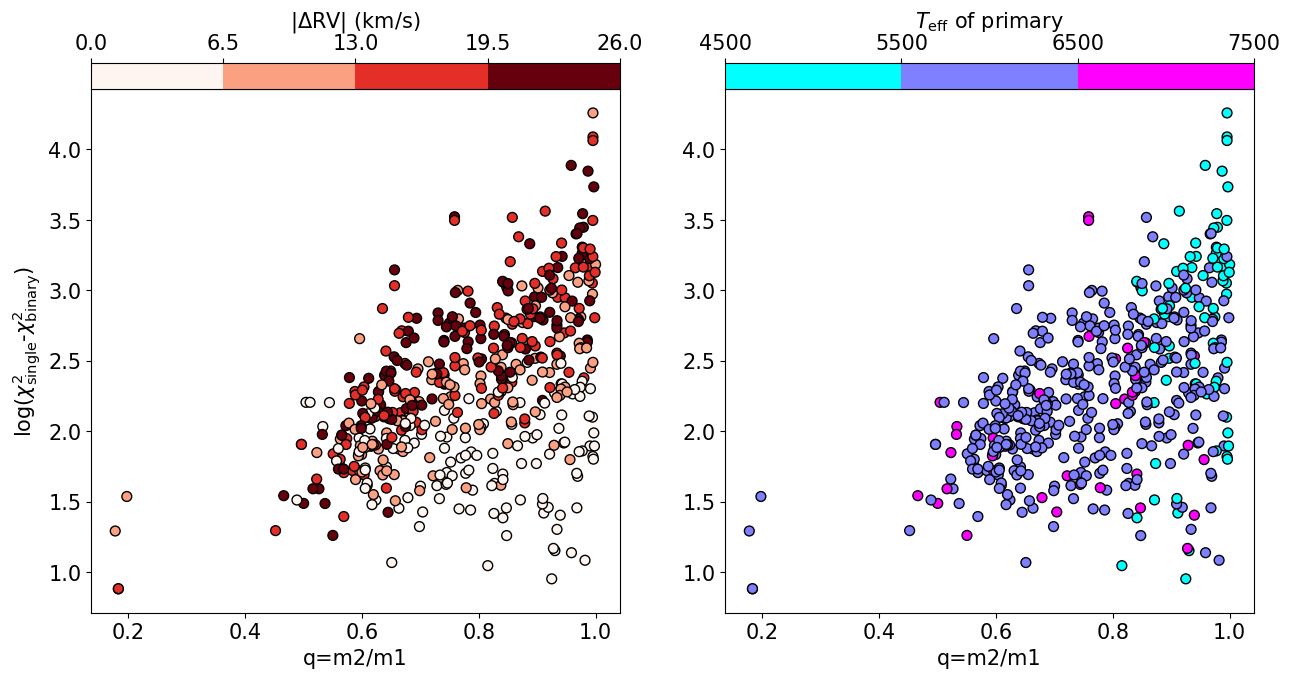

In [3]:
plt.rcParams['font.size']=15
plt.figure(figsize=(15,8))
plt.subplot(121)
drv_cmap = plt.cm.Reds
drv_norm = colors.BoundaryNorm(np.linspace(0,26,5), drv_cmap.N)
abs_drv = abs(sim_binaries.rv2_true - sim_binaries.rv1_true)
plt.scatter(sim_binaries.q_true, np.log10(sim_binaries.delta_chisq), c=abs_drv,
       marker='o', ec='k', s=50, cmap=drv_cmap, norm=drv_norm)
plt.colorbar(location='top', pad=0, label=r'|$\Delta$RV| (km/s)')
plt.xlabel('q=m2/m1');plt.ylabel(r'log($\chi^2_{\rm single}$-$\chi^2_{\rm binary}$)')


plt.subplot(122)
teff_cmap = plt.cm.cool
teff_norm = colors.BoundaryNorm(np.arange(4500,8500,1000), teff_cmap.N)
plt.scatter(sim_binaries.q_true, np.log10(sim_binaries.delta_chisq), c=sim_binaries.teff1_true,
       marker='o', ec='k', s=50, cmap=teff_cmap, norm=teff_norm)
plt.colorbar(location='top', pad=0, label=r'$T_{\rm eff}$ of primary')
plt.xlabel('q=m2/m1')

4 binaries in q range 0.15-0.25, 0 identified as binaries
0 binaries in q range 0.25-0.35, 0 identified as binaries
0 binaries in q range 0.35-0.45, 0 identified as binaries
16 binaries in q range 0.45-0.55, 0 identified as binaries
96 binaries in q range 0.55-0.65, 16 identified as binaries
96 binaries in q range 0.65-0.75, 48 identified as binaries
101 binaries in q range 0.75-0.85, 68 identified as binaries
116 binaries in q range 0.85-0.95, 90 identified as binaries
71 binaries in q range 0.95-1.05, 57 identified as binaries


Text(0, 0.5, 'completeness')

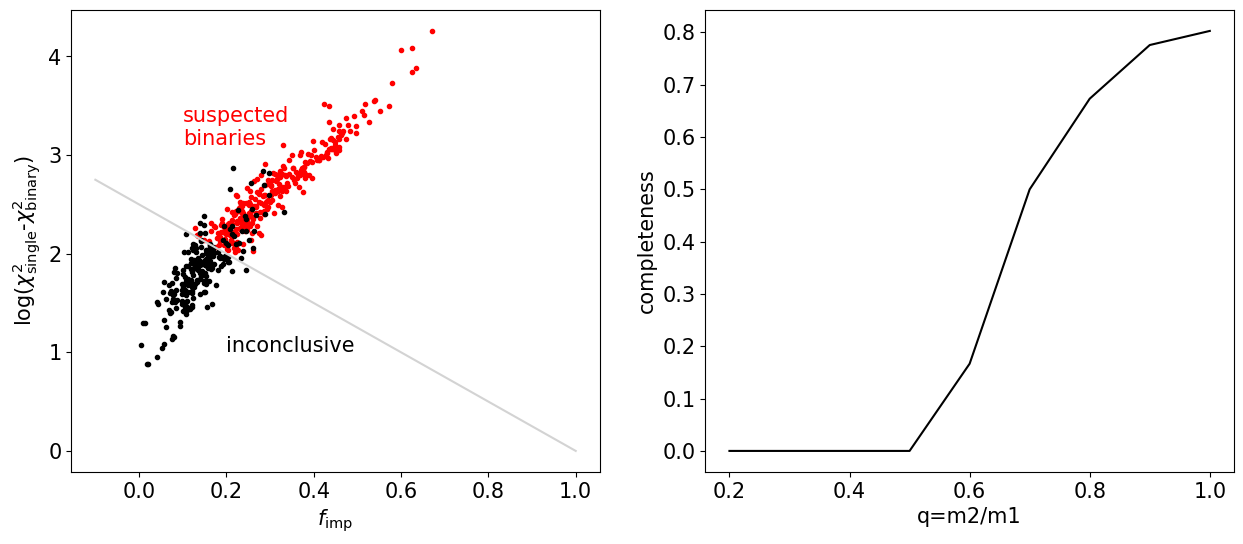

In [4]:
x1,x2 = [0.1,0.2]
y1,y2 = [2.25,2]#[2.5,2]
m = (y2-y1)/(x2-x1)
x = np.linspace(0,0.5,10)
y = m*(x-x1) + y1

x_threshold = np.linspace(-0.1,1,10)
y_threshold = m*(x_threshold-x1) + y1

# binaries are inupper right corner of f_imp/delta_chisq space, with high training density
conclusive_query_str = 'log10(delta_chisq) > @m*(f_imp - @x1) + @y1 & training_density1>1e-6 \
                    & training_density2 > 1e-6 & abs(rv2_cannon - rv2_cannon)< 26'
inconclusive_query_str = 'log10(delta_chisq) < @m*(f_imp - @x1) + @y1 | training_density1<1e-6 \
                    | training_density2 < 1e-6 | abs(rv2_cannon - rv2_cannon) > 26'
suspected_binaries = sim_binaries.query(conclusive_query_str)

inconclusive = sim_binaries.query(inconclusive_query_str)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(suspected_binaries.f_imp, np.log10(suspected_binaries.delta_chisq), '.', color='r')
plt.plot(inconclusive.f_imp, np.log10(inconclusive.delta_chisq), '.', color='k')
plt.plot(x_threshold, y_threshold, color='lightgrey')
plt.xlabel(r'$f_{\rm imp}$')
plt.ylabel(r'log($\chi^2_{\rm single}$-$\chi^2_{\rm binary}$)')
plt.text(0.1,3.1,'suspected\nbinaries', color='r')
plt.text(0.2,1,'inconclusive', color='k')


# need q bins
plt.subplot(122)
completeness = []
q_values = np.linspace(0.2, 1, 9)
for q_value in q_values:
    bin_min = q_value-0.05
    bin_max = q_value+0.05
    sim_binaries_q = sim_binaries.query('q_true > @bin_min & q_true < @bin_max')
    # then I need to find the fraction that are binaries
    sim_binaries_q_conclusive = sim_binaries_q.query(conclusive_query_str)
    print('{} binaries in q range {}-{}, {} identified as binaries'.format(
        len(sim_binaries_q), 
        np.round(bin_min, 2),
        np.round(bin_max, 2),
        len(sim_binaries_q_conclusive)))
    if len(sim_binaries_q)==0:
        completeness.append(0)
    else:
        completeness.append(len(sim_binaries_q_conclusive)/len(sim_binaries_q))

plt.plot(q_values, completeness, 'k-')
plt.xlabel('q=m2/m1')
plt.ylabel('completeness')

Text(0, 0.5, 'count')

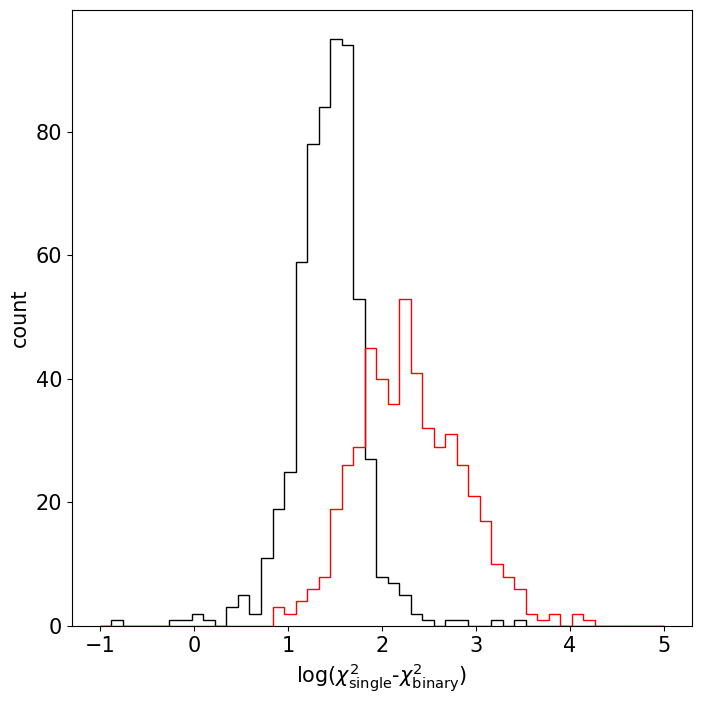

In [5]:
plt.figure(figsize=(8,8))
delta_chisq_bins = np.linspace(-1,5,50)
plt.hist(np.log10(singles.delta_chisq), color='k', histtype='step', bins=delta_chisq_bins)
plt.hist(np.log10(sim_binaries.delta_chisq), color='r', histtype='step', bins=delta_chisq_bins)
plt.xlabel(r'log($\chi^2_{\rm single}$-$\chi^2_{\rm binary}$)')
plt.ylabel('count')

Text(0, 0.5, 'count')

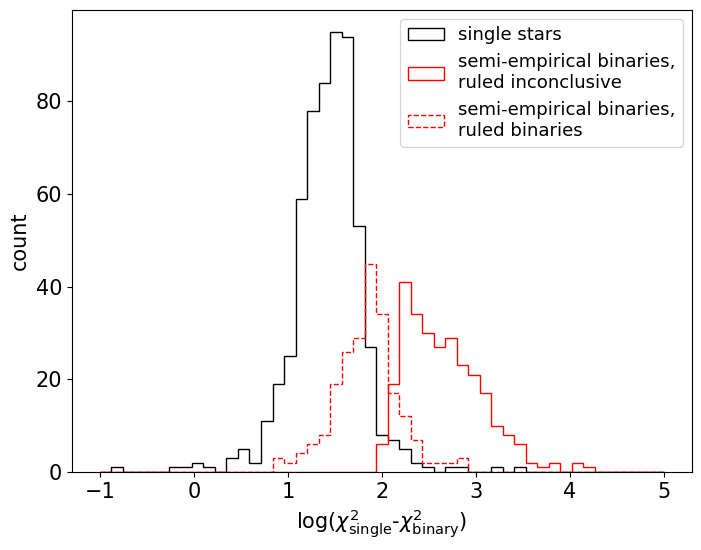

In [6]:
plt.figure(figsize=(8,6))
delta_chisq_bins = np.linspace(-1,5,50)
plt.hist(np.log10(singles.delta_chisq), color='k', histtype='step', 
         bins=delta_chisq_bins, label='single stars')
plt.hist(np.log10(suspected_binaries.delta_chisq), color='r', histtype='step', 
         bins=delta_chisq_bins, label='semi-empirical binaries,\nruled inconclusive')
plt.hist(np.log10(inconclusive.delta_chisq), color='r', histtype='step', 
         bins=delta_chisq_bins, ls='--', label='semi-empirical binaries,\nruled binaries')
plt.legend(fontsize=13)
plt.xlabel(r'log($\chi^2_{\rm single}$-$\chi^2_{\rm binary}$)')
plt.ylabel('count')

Text(0.1, 1, 'known singles')

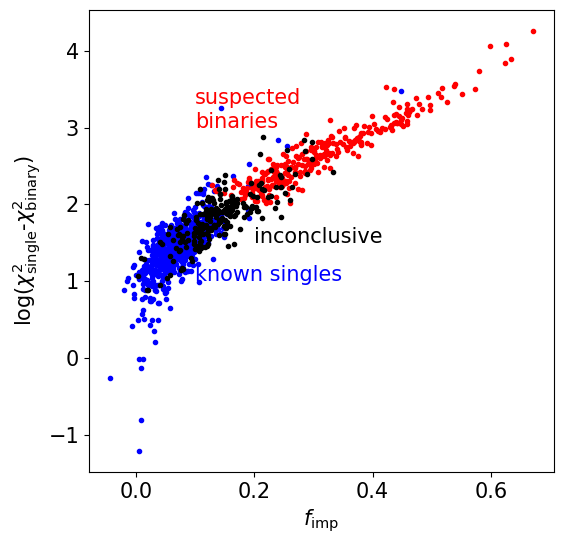

In [7]:
# next step: add single stars to plot
plt.figure(figsize=(6,6))
plt.plot(singles.f_imp, np.log10(singles.delta_chisq), '.', color='b')
plt.plot(suspected_binaries.f_imp, np.log10(suspected_binaries.delta_chisq), '.', color='r')
plt.plot(inconclusive.f_imp, np.log10(inconclusive.delta_chisq), '.', color='k')

plt.xlabel(r'$f_{\rm imp}$')
plt.ylabel(r'log($\chi^2_{\rm single}$-$\chi^2_{\rm binary}$)')
plt.text(0.1,3,'suspected\nbinaries', color='r')
plt.text(0.2,1.5,'inconclusive', color='k')
plt.text(0.1,1,'known singles', color='b')

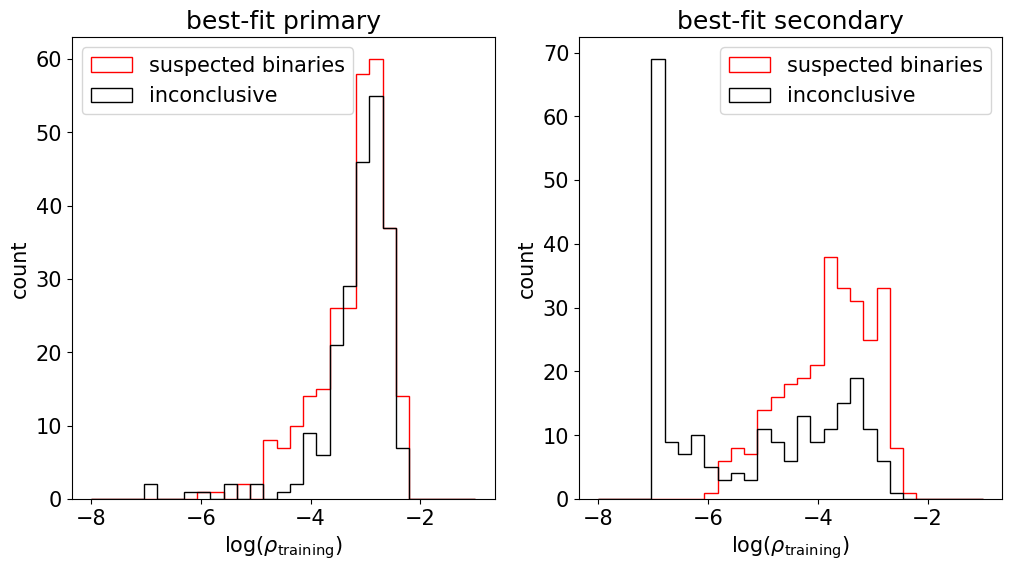

In [8]:
# sanity check: what are the training densities of the models?
# there is a small amount of binaries that we find where the secondary has a low training density
# so we aren't really finding those...or at least we can't trust the labels.
plt.figure(figsize=(12,6))
plt.subplot(121);plt.title('best-fit primary')
log_training_bins = np.linspace(-8,-1,30)
plt.hist(np.log10(suspected_binaries.training_density1), color='r', histtype='step', 
         label='suspected binaries', bins=log_training_bins) 
plt.hist(np.log10(inconclusive.training_density1), color='k', histtype='step', 
         label='inconclusive', bins=log_training_bins) 
plt.legend(fontsize=13)
plt.xlabel(r'log($\rho_{\rm training}$)')
plt.ylabel('count');plt.legend()

plt.subplot(122);plt.title('best-fit secondary')
delta_chisq_bins = np.linspace(-1,5,30)
plt.hist(np.log10(suspected_binaries.training_density2), color='r', histtype='step', 
         label='suspected binaries', bins=log_training_bins) 
plt.hist(np.log10(inconclusive.training_density2), color='k', histtype='step', 
         label='inconclusive', bins=log_training_bins) 
plt.legend(fontsize=13)
plt.xlabel(r'log($\rho_{\rm training}$)')
plt.ylabel('count');plt.legend()

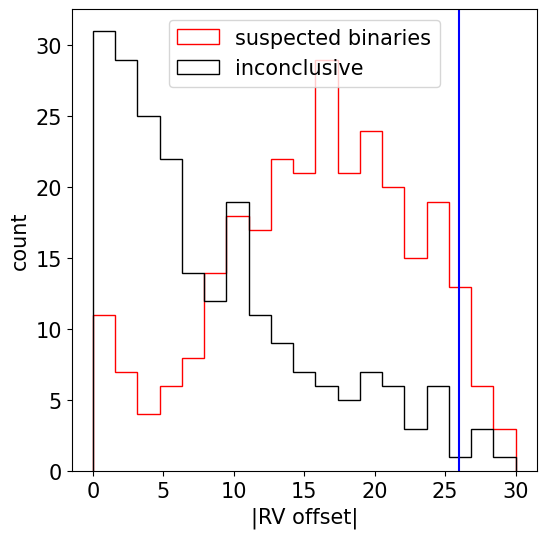

In [9]:
plt.figure(figsize=(6,6))
drv_bins = np.linspace(0,30,20)
plt.hist(abs(suspected_binaries.rv1_cannon - suspected_binaries.rv2_cannon), color='r', histtype='step', 
         label='suspected binaries', bins=drv_bins) 
plt.hist(abs(inconclusive.rv1_cannon - inconclusive.rv2_cannon), color='k', histtype='step', 
         label='inconclusive', bins=drv_bins) 
plt.legend(fontsize=13)
plt.axvline(26, color='b')
plt.xlabel(r'|RV offset|')
plt.ylabel('count');plt.legend()

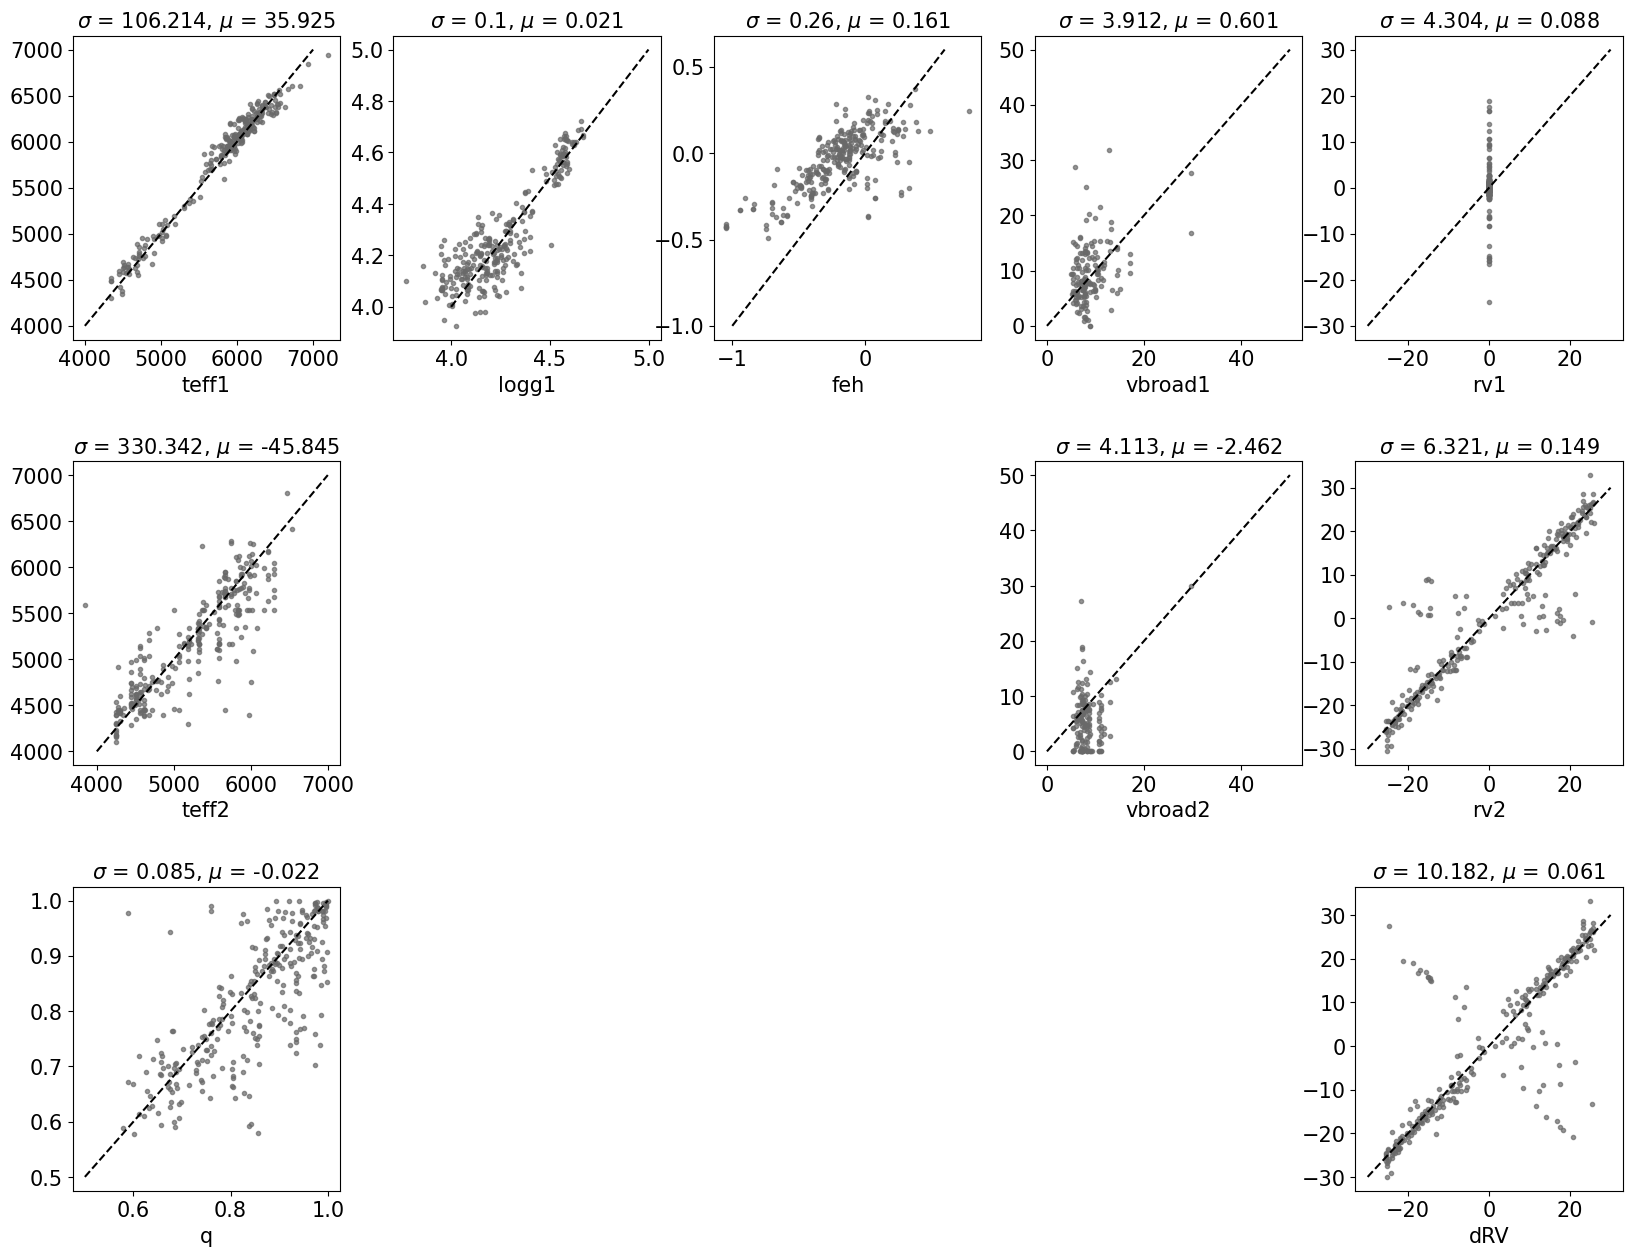

In [10]:
# this plot is very revealing.
# there is something going on with q and drv...
# I'll need to look into this further.
# function to compute teff2
def teff2(df_teff1, df_q):
    m1 = custom_model.teff2mass(df_teff1)
    m2 = m1 * df_q
    teff2 = custom_model.mass2teff(m2)
    return teff2

def plot_one2one(x, y):
    plt.plot(x, y, '.', 
         color='dimgrey', alpha=0.7)
    diff = y - x
    bias = np.round(np.mean(diff), 3)
    rms = np.round(np.sqrt(np.sum(diff**2)/len(diff)), 3)
    label = r'$\sigma$ = {}, $\mu$ = {}'.format(rms, bias)
    plt.title(label, fontsize=15)

plt.figure(figsize=(20,15))
plt.subplot(351)
plot_one2one(suspected_binaries.teff1_true, suspected_binaries.teff1_cannon)
plt.plot([4000,7000],[4000,7000], 'k--')
plt.xlabel('teff1')

plt.subplot(352)
plot_one2one(suspected_binaries.logg1_true, suspected_binaries.logg1_cannon)
plt.plot([4,5],[4,5], 'k--')
plt.xlabel('logg1')

plt.subplot(353)
plot_one2one(suspected_binaries.feh_true, suspected_binaries.feh_cannon)
plt.plot([-1,0.6],[-1,0.6], 'k--')
plt.xlabel('feh')

plt.subplot(354)
plot_one2one(suspected_binaries.vbroad1_true, suspected_binaries.vbroad1_cannon)
plt.plot([0,50],[0,50], 'k--')
plt.xlabel('vbroad1')

plt.subplot(355)
plot_one2one(suspected_binaries.rv1_true, suspected_binaries.rv1_cannon)
plt.plot([-30,30],[-30,30], 'k--')
plt.xlabel('rv1')

plt.subplot(356)
teff2_true = teff2(suspected_binaries.teff1_true, suspected_binaries.q_true)
teff2_cannon = teff2(suspected_binaries.teff1_cannon, suspected_binaries.q_cannon)
plot_one2one(teff2_true, teff2_cannon)
plt.plot([4000,7000],[4000,7000], 'k--')
plt.xlabel('teff2')

plt.subplot(359)
plot_one2one(suspected_binaries.vbroad2_true, suspected_binaries.vbroad2_cannon)
plt.plot([0,50],[0,50], 'k--')
plt.xlabel('vbroad2')

plt.subplot(3,5,10)
plot_one2one(suspected_binaries.rv2_true, suspected_binaries.rv2_cannon)
plt.plot([-30,30],[-30,30], 'k--')
plt.xlabel('rv2')

plt.subplot(3,5,11)
plot_one2one(suspected_binaries.q_true, suspected_binaries.q_cannon)
plt.plot([0.5,1],[0.5,1], 'k--')
plt.xlabel('q')
plt.subplots_adjust(hspace=0.4)

plt.subplot(3,5,15)
plot_one2one(suspected_binaries.rv2_true - suspected_binaries.rv1_true, 
             suspected_binaries.rv2_cannon - suspected_binaries.rv1_cannon)
plt.plot([-30,30],[-30,30], 'k--')
plt.xlabel('dRV')
plt.subplots_adjust(hspace=0.4)

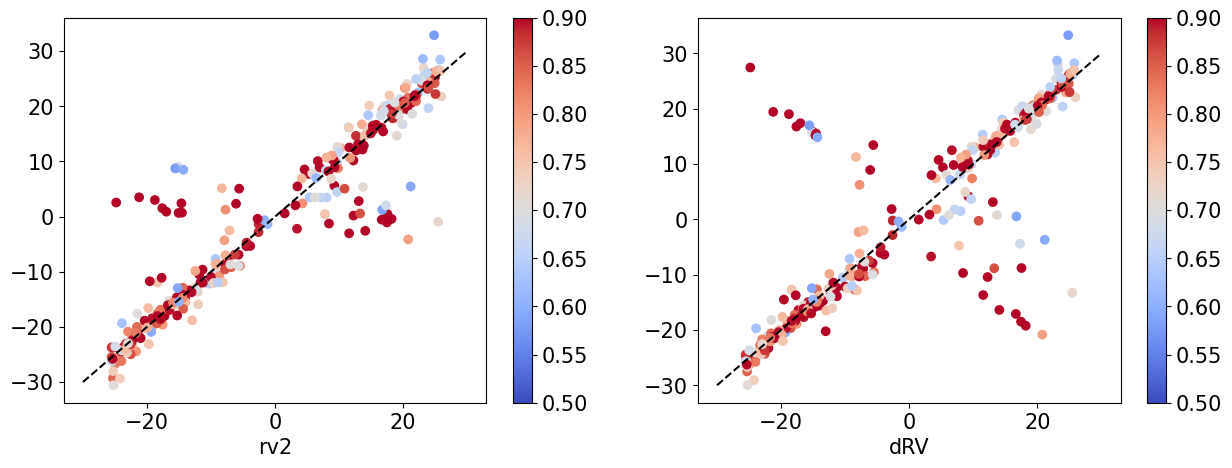

In [11]:
# what is happeninng with the RV panels?
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(suspected_binaries.rv2_true, suspected_binaries.rv2_cannon, 
            c=suspected_binaries.q_cannon, vmin=0.5,vmax=0.9, cmap='coolwarm')
plt.plot([-30,30],[-30,30], 'k--')
plt.xlabel('rv2');plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(suspected_binaries.rv2_true - suspected_binaries.rv1_true, 
             suspected_binaries.rv2_cannon - suspected_binaries.rv1_cannon,
             c=suspected_binaries.q_cannon, vmin=0.5,vmax=0.9, cmap='coolwarm')
plt.plot([-30,30],[-30,30], 'k--')
plt.xlabel('dRV');plt.colorbar()
plt.subplots_adjust(hspace=0.4)

Text(0.2, 1.1, 'RV offset > 26km/s, inconclusive')

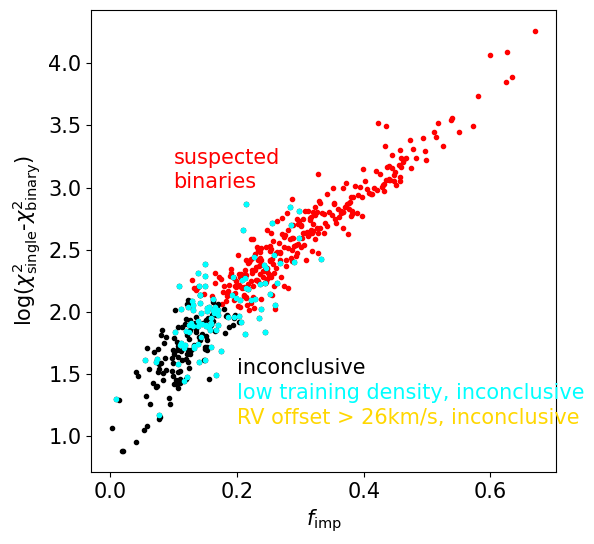

In [12]:
# next step: add single stars to plot

low_density = sim_binaries.query('training_density1<1e-6 | training_density2<1e-6')
large_drv = sim_binaries.query('abs(rv2_cannon - rv2_cannon)>26')


plt.figure(figsize=(6,6))
plt.plot(suspected_binaries.f_imp, np.log10(suspected_binaries.delta_chisq), '.', color='r')
plt.plot(inconclusive.f_imp, np.log10(inconclusive.delta_chisq), '.', color='k')
plt.plot(low_density.f_imp, np.log10(low_density.delta_chisq), '.', color='cyan')
plt.plot(large_drv.f_imp, np.log10(large_drv.delta_chisq), '*', color='gold')

plt.xlabel(r'$f_{\rm imp}$')
plt.ylabel(r'log($\chi^2_{\rm single}$-$\chi^2_{\rm binary}$)')
plt.text(0.1,3,'suspected\nbinaries', color='r')
plt.text(0.2,1.5,'inconclusive', color='k')
plt.text(0.2,1.3,'low training density, inconclusive', color='cyan')
plt.text(0.2,1.1,'RV offset > 26km/s, inconclusive', color='gold')